In [1]:
%cd /qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1

/qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1


In [2]:
import numpy as np
import pickle
from sklearn import decomposition
from scipy.stats import spearmanr
from functools import reduce
import matplotlib.ticker as ticker
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO
import matplotlib.colors as mcolors
import pylab as pl
from collections import Counter
from matplotlib import colors as colors

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_style("whitegrid")

# fig.patch.set_facecolor('white')
%matplotlib inline

In [3]:
trgenename = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/Mouse-SCV2.transcript-genenames.txt', sep='\t', names=['transcript_id', 'gene_name'], index_col=0)
codinglengths = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/transcript-coding-lengths.txt', sep='\t',
                            names='transcript_id gene_id utr5 cds utr3 noncoding'.split())

repisoform = pickle.load(open('/qbio/junsoopablo//02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/representative-isoforms.pickle','rb'))


codinglengths['genesize'] = codinglengths['utr5'] + codinglengths['cds'] + codinglengths['utr3']
codinglengths_gene = pd.merge(codinglengths, trgenename, how='inner', left_on='transcript_id', right_index=True)
codinglengths_gene = codinglengths_gene.loc[codinglengths_gene['transcript_id'].isin(repisoform['transcript_id'])]

cdslen_dic = codinglengths_gene.set_index('transcript_id')['cds'].to_dict()
utr3len_dic = codinglengths_gene.set_index('transcript_id')['utr3'].to_dict()
gene_dic = codinglengths_gene.copy(deep=True)
gene_dic['gene_id'] = gene_dic['gene_id'].str.split('.',expand=True)[0]
gene_dic = gene_dic.set_index('transcript_id')['gene_id'].to_dict()

genelen_dic = codinglengths_gene.set_index('transcript_id')['genesize'].to_dict()
genesym_dic = codinglengths_gene[['gene_id', 'gene_name']]
genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]
genesym_dic = genesym_dic.set_index('gene_id')['gene_name'].to_dict()


codinglengths_gene.head()

/tmp/ipykernel_151762/1395101429.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]


,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
0,ENSMUST00000000001.5,ENSMUSG00000000001.5,141,1065,2056,0,3262,Gnai3
1,ENSMUST00000000003.14,ENSMUSG00000000003.16,140,525,237,0,902,Pbsn
2,ENSMUST00000000010.9,ENSMUSG00000020875.10,85,753,1736,0,2574,Hoxb9
3,ENSMUST00000000028.14,ENSMUSG00000000028.16,313,1701,129,0,2143,Cdc45
5,ENSMUST00000000049.6,ENSMUSG00000000049.12,51,1038,101,0,1190,Apoh


In [4]:
codinglengths_gene.loc[codinglengths_gene['gene_name']=='Rpl26']

,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
75713,ENSMUST00000167436.3,ENSMUSG00000060938.15,128,438,40,0,606,Rpl26


# Convert genome bam to transcript bam

In [5]:
! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
    sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
        --in filtered-RPF-siLuc.bam --out filtered-RPF-siLuc_transcriptome_tmp.bam --single --reverse
! samtools view -h filtered-RPF-siLuc_transcriptome_tmp.bam | \
        awk -vOFS='\t' '/^@/ { print $0; } \
        /^[^@]/ { $2 = xor($2, 8); print }' | \
    samtools sort -@ 10 --write-index -o filtered-RPF-siLuc_transcriptome.bam -

Starting Fri May 27 12:36:47 KST 2022
Parsing arguments
bedFile: /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12
readOffset: 25
inputAlignmentFile: filtered-RPF-siLuc.bam
outputAlignmentFile: filtered-RPF-siLuc_transcriptome_tmp.bam
orderFastaFile: not specified
positiveStrandReportingOnly: false
xgtags: false
single: true

Skipping isoform header order determination
Building read index
Loaded 10001 isoforms.
Loaded 20001 isoforms.
Loaded 30001 isoforms.
Loaded 40001 isoforms.
Loaded 50001 isoforms.
Loaded 60001 isoforms.
Loaded 70001 isoforms.
Loaded 80001 isoforms.
Loaded 90001 isoforms.
Loaded 100001 isoforms.
Loaded 110001 isoforms.
Loaded 120001 isoforms.
Loaded 130001 isoforms.
Loaded 140001 isoforms.
Converting
Reading file: filtered-RPF-siLuc.bam
Writing to file: filtered-RPF-siLuc_transcriptome_tmp.bam
Writing header
Processing single end reads
Indexing isoforms for: chr1
Processed 1 reads.
^C
[W::bam_hdr_read] EOF marker is

In [ ]:
! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
    sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
        --in filtered-RPF-siLin28a.bam --out filtered-RPF-siLin28a_transcriptome_tmp.bam --single --reverse
! samtools view -h filtered-RPF-siLin28a_transcriptome_tmp.bam | \
        awk -vOFS='\t' '/^@/ { print $0; } \
        /^[^@]/ { $2 = xor($2, 8); print }' | \
    samtools sort -@ 10 --write-index -o filtered-RPF-siLin28a_transcriptome.bam -

Starting Tue May 17 18:01:44 KST 2022
Parsing arguments
bedFile: /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12
readOffset: 25
inputAlignmentFile: filtered-RPF-siLin28a.bam
outputAlignmentFile: filtered-RPF-siLin28a_transcriptome_tmp.bam
orderFastaFile: not specified
positiveStrandReportingOnly: false
xgtags: false
single: true

Skipping isoform header order determination
Building read index
Loaded 10001 isoforms.
Loaded 20001 isoforms.
Loaded 30001 isoforms.
Loaded 40001 isoforms.
Loaded 50001 isoforms.
Loaded 60001 isoforms.
Loaded 70001 isoforms.
Loaded 80001 isoforms.
Loaded 90001 isoforms.
Loaded 100001 isoforms.
Loaded 110001 isoforms.
Loaded 120001 isoforms.
Loaded 130001 isoforms.
Loaded 140001 isoforms.
Converting
Reading file: filtered-RPF-siLin28a.bam
Writing to file: filtered-RPF-siLin28a_transcriptome_tmp.bam
Writing header
Processing single end reads
Indexing isoforms for: chr1
Processed 1 reads.
Indexing isoforms for:

# convert bam to rpf counts

In [ ]:
!bedtools genomecov -ibam filtered-RPF-siLuc_transcriptome.bam -bg -5 > siLuc_transcriptome.bed
!head siLuc_transcriptome.bed

ENSMUST00000018875.13	199	200	1
ENSMUST00000018875.13	201	202	1
ENSMUST00000018875.13	224	225	1
ENSMUST00000018875.13	233	234	16
ENSMUST00000018875.13	234	235	5
ENSMUST00000018875.13	236	238	2
ENSMUST00000018875.13	238	239	1
ENSMUST00000018875.13	240	241	1
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	249	250	3


In [ ]:
!bedtools genomecov -ibam filtered-RPF-siLin28a_transcriptome.bam -bg -5 > siLin28a_transcriptome.bed
!head siLin28a_transcriptome.bed

ENSMUST00000018875.13	202	203	1
ENSMUST00000018875.13	220	221	1
ENSMUST00000018875.13	223	224	2
ENSMUST00000018875.13	226	227	1
ENSMUST00000018875.13	233	235	2
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	255	256	1
ENSMUST00000018875.13	256	257	2
ENSMUST00000018875.13	258	261	1
ENSMUST00000018875.13	273	274	1


# Identify transmembrane segments

In [7]:
protstbl = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-localization-tags.pickle', 'rb'))
uniprot_ensgene_map = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-ensembl-mapping.pickle', 'rb'))
protstbl = pd.merge(protstbl,uniprot_ensgene_map, left_on='ID', right_on='uniprot_id')
protstbl

,ID,topology,length,annotags,subcellular location,tissue specificity,tail-anchored,Apical cell membrane,Basolateral cell membrane,Cell junction,...,have-nterm-signal,have-signal,have-subcellular-location,nterm-cytoplasmic,nterm-extracellular,nterm-lumenal,nterm-mitochondrial intermembrane,nterm-mitochondrial matrix,uniprot_id,ensembl_gene_id
0,A0A075B5J2_MOUSE,"{'SIGNAL': [(0, 15, {'evidence': 'ECO:0000256|...",110,"{have-signal, have-nterm-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A075B5J2_MOUSE,ENSMUSG00000076481
1,A0A0A6YYE5_MOUSE,"{'SIGNAL': [(0, 22, {'evidence': 'ECO:0000256|...",119,"{have-signal, have-nterm-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A0A6YYE5_MOUSE,ENSMUSG00000094315
2,A0A1B0GT27_MOUSE,NaN,204,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT27_MOUSE,ENSMUSG00000108348
3,A0A1B0GT39_MOUSE,NaN,78,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT39_MOUSE,ENSMUSG00000109833
4,A0A286YDL3_MOUSE,NaN,209,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A286YDL3_MOUSE,ENSMUSG00000099655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31890,TSLP_MOUSE,"{'SIGNAL': [(0, 19, {'evidence': 'ECO:0000255'...",140,"{have-subcellular-location, have-signal, Secre...","[(Secreted, [ECO:0000269|PubMed:10974033])]",NaN,False,False,False,False,...,True,True,True,False,False,False,False,False,TSLP_MOUSE,ENSMUSG00000024379
31891,SERC3_MOUSE,"{'TOPO_DOM': [(0, 96, {'note': 'Extracellular'...",472,"{Golgi apparatus membrane, cterm-extracellular...","[(Cell membrane, [ECO:0000269|PubMed:12486168]...",Highly expressed in the neuronal populations s...,False,False,False,False,...,False,False,True,False,True,False,False,False,SERC3_MOUSE,ENSMUSG00000017707
31892,SAE1_MOUSE,NaN,350,"{have-subcellular-location, Nucleus}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833
31893,SAE1_MOUSE,NaN,350,"{have-subcellular-location, Nucleus}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833


In [8]:
signal_genes = protstbl.loc[protstbl['have-signal']==True]
signal_genes = signal_genes['ensembl_gene_id'].to_list()

tail_genes = protstbl.loc[protstbl['tail-anchored']==True]
tail_genes = tail_genes['ensembl_gene_id'].to_list()

multi_genes = protstbl.loc[protstbl['Multi-pass membrane protein']==True]
single_genes = protstbl.loc[protstbl['Single-pass membrane protein']==True]

multi_genes = multi_genes['ensembl_gene_id'].to_list()
single_genes = single_genes['ensembl_gene_id'].to_list()
transmem_dic = {'multi':multi_genes, 'single':single_genes}
transmem_dic = {k: oldk for oldk, oldv in transmem_dic.items() for k in oldv}


In [206]:
membrane_prot = protstbl.loc[(protstbl['Single-pass membrane protein']==True) | (protstbl['Multi-pass membrane protein']==True)]
#['ensembl_gene_id'].unique()
membrane_prot = membrane_prot[['ensembl_gene_id','topology']]
membrane_prot['transmembrane1'] = membrane_prot['topology'].apply(lambda x: x.get('TRANSMEM') if isinstance(x, dict)==True else '')
membrane_prot['transmembrane'] = membrane_prot['transmembrane1'].apply(lambda x: [(i[0]*3,i[1]*3+3) for i in x] if isinstance(x, list)==True else '')
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot

,ensembl_gene_id,topology,transmembrane1,transmembrane
7,ENSMUSG00000078599,"{'SIGNAL': [(0, 25, {'evidence': 'ECO:0000255'...","[(244, 265, {'note': 'Helical', 'evidence': 'E...","[(732, 798), (864, 930), (993, 1059)]"
30,ENSMUSG00000091682,"{'TRANSMEM': [(137, 160, {'note': 'Helical', '...","[(137, 160, {'note': 'Helical', 'evidence': 'E...","[(411, 483)]"
39,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
40,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
41,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
...,...,...,...,...
31869,ENSMUSG00000035559,"{'TRANSMEM': [(23, 40, {'note': 'Helical', 'ev...","[(23, 40, {'note': 'Helical', 'evidence': 'ECO...","[(69, 123), (186, 252), (303, 369)]"
31873,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31874,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31886,ENSMUSG00000064158,"{'SIGNAL': [(0, 21, {'evidence': 'ECO:0000255'...","[(319, 340, {'note': 'Helical', 'evidence': 'E...","[(957, 1023)]"


In [207]:
def select_signal(row):
    if row==None: return None
    if row[0][1]==None: return None
    else:
        return [row[0][0]*3, row[0][1]*3]

In [208]:
membrane_prot['signalpeptide1'] = membrane_prot['topology'].apply(lambda x: x.get('SIGNAL') if isinstance(x, dict)==True else '')
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide1'].apply(lambda x: select_signal(x))
membrane_prot = membrane_prot.drop(columns=['transmembrane1','signalpeptide1','topology'])
membrane_prot['transtype'] = transmem_region(membrane_prot, 'ensembl_gene_id')
membrane_prot

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
40,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
41,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
...,...,...,...,...
31869,ENSMUSG00000035559,"[(69, 123), (186, 252), (303, 369)]",None,Multi-pass
31873,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31874,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31886,ENSMUSG00000064158,"[(957, 1023)]","[0, 63]",N-term signal


In [209]:
nsignal_prot_dic = membrane_prot.loc[(membrane_prot['transtype']=='N-term signal') & (membrane_prot['signalpeptide']!='None')]
# signal_prot['signalpeptide'] = signal_prot['signalpeptide'].astype('list')
nsignal_prot_dic = nsignal_prot_dic[['ensembl_gene_id','signalpeptide']]
nsignal_prot_dic.set_index('ensembl_gene_id', inplace=True)
nsignal_prot_dic = nsignal_prot_dic.to_dict()['signalpeptide']
nsignal_prot_dic

{'ENSMUSG00000037157': [0, 45],
 'ENSMUSG00000103567': [0, 72],
 'ENSMUSG00000055471': [0, 54],
 'ENSMUSG00000029377': [0, 66],
 'ENSMUSG00000026442': [0, 72],
 'ENSMUSG00000039156': [0, 42],
 'ENSMUSG00000020717': [0, 51],
 'ENSMUSG00000048234': [0, 93],
 'ENSMUSG00000045631': [0, 54],
 'ENSMUSG00000063900': [0, 66],
 'ENSMUSG00000030281': [0, 63],
 'ENSMUSG00000060548': [0, 87],
 'ENSMUSG00000036503': [0, 102],
 'ENSMUSG00000040680': [0, 72],
 'ENSMUSG00000009291': [0, 87],
 'ENSMUSG00000025652': [0, 66],
 'ENSMUSG00000053216': [0, 87],
 'ENSMUSG00000040522': [0, 69],
 'ENSMUSG00000058398': [0, 81],
 'ENSMUSG00000007440': [0, 90],
 'ENSMUSG00000021991': [0, 99],
 'ENSMUSG00000079491': [0, 57],
 'ENSMUSG00000040118': [0, 72],
 'ENSMUSG00000103458': [0, 87],
 'ENSMUSG00000104252': [0, 87],
 'ENSMUSG00000028226': [0, 93],
 'ENSMUSG00000045589': [0, 84],
 'ENSMUSG00000001029': [0, 66],
 'ENSMUSG00000028664': [0, 54],
 'ENSMUSG00000032336': [0, 84],
 'ENSMUSG00000046480': [0, 90],
 'ENSMU

In [193]:
membrane_prot['transmembrane'] = membrane_prot['transmembrane'].astype(str)
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide'].astype(str)

membrane_prot = membrane_prot.drop_duplicates()
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
63,ENSMUSG00000042793,"[(1701, 1767), (1794, 1860), (1932, 1998), (20...","[0, 66]",Multi-pass
68,ENSMUSG00000026904,"[(1527, 1593), (1614, 1680), (1686, 1752), (17...",None,Multi-pass
...,...,...,...,...
31864,ENSMUSG00000064121,"[(78, 153), (183, 243), (297, 366), (420, 498)...",None,Multi-pass
31869,ENSMUSG00000035559,"[(69, 123), (186, 252), (303, 369)]",None,Multi-pass
31873,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31886,ENSMUSG00000064158,"[(957, 1023)]","[0, 63]",N-term signal


In [232]:
membrane_prot.loc[membrane_prot['signalpeptide'].notnull()]

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
63,ENSMUSG00000042793,"[(1701, 1767), (1794, 1860), (1932, 1998), (20...","[0, 66]",Multi-pass
73,ENSMUSG00000031616,"[(240, 309), (336, 399), (477, 546), (615, 690...","[0, 60]",Multi-pass
81,ENSMUSG00000037157,"[(690, 756)]","[0, 45]",N-term signal
109,ENSMUSG00000103567,"[(2064, 2145)]","[0, 72]",N-term signal
...,...,...,...,...
31814,ENSMUSG00000032180,"[(582, 648)]","[0, 72]",N-term signal
31832,ENSMUSG00000000706,"[(741, 807)]","[0, 78]",N-term signal
31833,ENSMUSG00000007613,"[(378, 444)]","[0, 87]",N-term signal
31834,ENSMUSG00000007613,"[(378, 444)]","[0, 87]",N-term signal


In [148]:
import ast
from collections import defaultdict
membrane_dic = defaultdict(list)
membrane_list = []
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)
    region = trans[0]
    membrane_dic[gene] += list(range(region[0],region[1]))
    membrane_list.append(region[1]-region[0]+1)
    # for region in trans:
    #     membrane_dic[gene] += list(range(region[0],region[1]))
    #     membrane_list.append(region[1]-region[0]+1)

In [149]:
import ast
from collections import defaultdict

Dist = 150
peakmid_dic = defaultdict(list)
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)

    peakmid_dic[gene]
    region = trans[0]
    # for region in trans:
    midsite = int((region[1]+region[0])/2) 
    if midsite > Dist:
        peakmid_dic[gene] += [midsite]

peakmid_dic = {k:v for k,v in peakmid_dic.items() if len(v)>0}

# Select highly expressing genes

In [150]:
def select_highly_expressing_genes(file):
    rpf_all = pd.read_csv(file, sep='\t', names=['transcript_id','start','end','count'])
    # select representative isoforms
    rpf_all = pd.merge(rpf_all, codinglengths_gene, on='transcript_id', how='inner')
    rpf_all['reltostart-asite'] = rpf_all['start'] - rpf_all['utr5'] + 18
    rpf_all = rpf_all.loc[rpf_all['reltostart-asite']>0]
    # select highly expressing genes
    rpf = rpf_all.groupby(['gene_name','transcript_id']).sum().sort_values(by='count', ascending=False)[['count']].reset_index()
    total_read = rpf['count'].sum()
    rpf['rpm'] = rpf['count']/total_read * 10e5
    high_rpf = rpf.loc[rpf['rpm']>=1].copy()
    high_rpf = rpf_all.loc[rpf_all['transcript_id'].isin(high_rpf['transcript_id'])].copy()
    high_rpf['gene_id'] = high_rpf['gene_id'].str.split('.',expand=True)[0]
    high_rpf['rpm'] = high_rpf['count']/total_read * 10e5
    high_rpf = high_rpf[['gene_name','gene_id','transcript_id','reltostart-asite','rpm']]
    return high_rpf


In [151]:
def get_transmem_dist(df, Dist):
    df = df.loc[df['gene_id'].isin(peakmid_dic.keys())].copy()
    df['dist_from_center'] = df.apply(lambda y: min(peakmid_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite'])) - y['reltostart-asite'] if (y['gene_id'] in peakmid_dic.keys()) else None, axis=1)
    df = df.loc[abs(df['dist_from_center'])<Dist]
    df['region'] = np.where(df['dist_from_center'].isin(range(-70,71)), 'transmembrane',
                                        np.where(df['dist_from_center']>0, 'downstream', 'upstream'))
    return df


In [152]:
def trans_typing(df, ratio=True):
    df['trans_type'] = np.where(df['gene_id'].isin(tail_genes), 'Tail-anchored',
                                            np.where(df['gene_id'].isin(multi_genes), 'Multi-pass',
                                                    np.where(df['gene_id'].isin(signal_genes), 'N-term signal',
                                                            np.where(df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
    df_ratio = df.groupby(['gene_id','trans_type','region']).sum()['count']
    df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
    if ratio==True:
        df_ratio = df_ratio / df_ratio.sum(level='gene_id')
        df_ratio = df_ratio.to_frame(name='ratio').reset_index()
        return(df_ratio)
    else:
        df_ratio = df_ratio.to_frame(name='count').reset_index()
        return(df_ratio)

# Reproduce Figure5D

In [168]:
def transmem_region(df, genecol):
    return (np.where(df[genecol].isin(tail_genes), 'Tail-anchored',
                    np.where(df[genecol].isin(multi_genes), 'Multi-pass',
                            np.where(df[genecol].isin(signal_genes), 'N-term signal',
                                    np.where(df[genecol].isin(single_genes), 'No N-term signal', 'Non-ER-associated')))))

In [154]:
select_highly_expressing_genes('siLuc_transcriptome.bed')

,gene_name,gene_id,transcript_id,reltostart-asite,rpm
41,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,2,0.053680
42,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,5,0.107360
43,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,6,0.053680
44,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,9,0.161040
45,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,12,1.019921
...,...,...,...,...,...
1589822,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1698,0.053680
1589823,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1700,0.053680
1589824,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1742,0.053680
1589825,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,2471,0.053680


In [155]:
siLuc_df= select_highly_expressing_genes('siLuc_transcriptome.bed')
# siLuc_df['region'] = transmem_region(siLuc_df)
siLuc_df = siLuc_df.groupby(['gene_id']).sum()[['rpm']]

siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]
siLin28a_df

# siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
# siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]

# siLuc_df['trans_type'] = np.where(siLuc_df['gene_id'].isin(tail_genes), 'Tail-anchored',
#                                             np.where(siLuc_df['gene_id'].isin(multi_genes), 'Multi-pass',
#                                                     np.where(siLuc_df['gene_id'].isin(signal_genes), 'N-term signal',
#                                                             np.where(siLuc_df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))


,rpm
gene_id,
ENSMUSG00000000037,1.273534
ENSMUSG00000000056,8.348723
ENSMUSG00000000078,6.862933
ENSMUSG00000000085,1.981053
ENSMUSG00000000088,285.413125
...,...
ENSMUSG00000119895,777.917033
ENSMUSG00000119899,22.074590
ENSMUSG00000119938,14.221130


In [156]:
merge_df = pd.merge(siLuc_df, siLin28a_df, on='gene_id', how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_df['ratio'] = merge_df['rpm_siLin28a'] / merge_df['rpm_siLuc']
merge_df['log2ratio'] = np.log2(merge_df['ratio'])
merge_df.reset_index(inplace=True)
merge_df['region'] = transmem_region(merge_df)
merge_df

,gene_id,rpm_siLuc,rpm_siLin28a,ratio,log2ratio,region
0,ENSMUSG00000000037,4.455444,1.273534,0.285838,-1.806732,Non-ER-associated
1,ENSMUSG00000000056,8.159367,8.348723,1.023207,0.033098,Non-ER-associated
2,ENSMUSG00000000078,6.226886,6.862933,1.102145,0.140315,Non-ER-associated
3,ENSMUSG00000000085,2.791363,1.981053,0.709708,-0.494702,Non-ER-associated
4,ENSMUSG00000000088,198.455142,285.413125,1.438175,0.524239,Non-ER-associated
...,...,...,...,...,...,...
9121,ENSMUSG00000119895,415.054140,777.917033,1.874254,0.906317,Non-ER-associated
9122,ENSMUSG00000119899,26.947385,22.074590,0.819174,-0.287759,Non-ER-associated
9123,ENSMUSG00000119938,20.505779,14.221130,0.693518,-0.527994,Non-ER-associated
9124,ENSMUSG00001118661,11.219130,10.683535,0.952261,-0.070572,Non-ER-associated


[Text(0, 0, 'Non-ER-associated'),
 Text(1, 0, 'Tail-anchored'),
 Text(2, 0, 'No N-term signal'),
 Text(3, 0, 'N-term signal'),
 Text(4, 0, 'Multi-pass')]

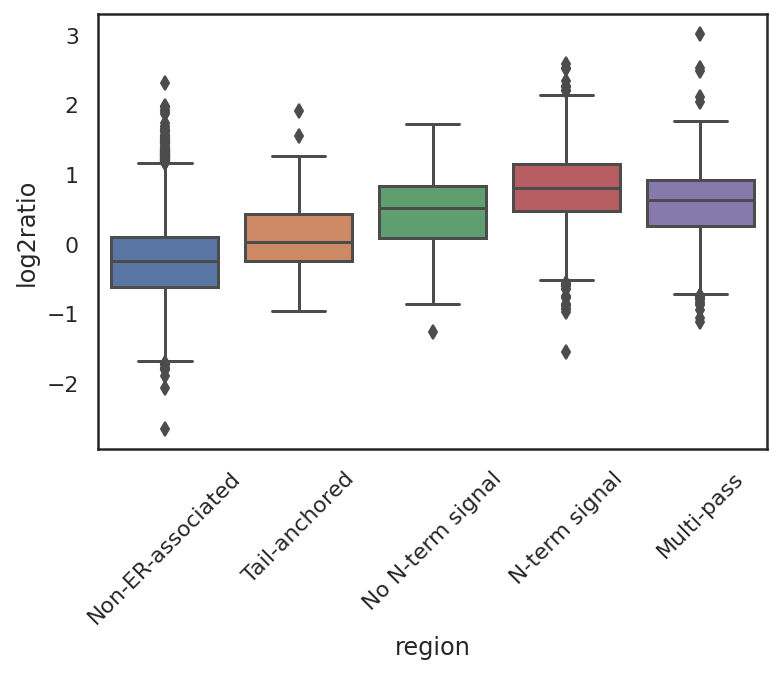

In [157]:
g = sns.boxplot(data=merge_df, x='region', y='log2ratio', order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
g.set_xticklabels(g.get_xticklabels(), rotation=45)


# Test if ribosome stall at N-term signal

In [252]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')


In [309]:
siLuc_df['signaldist'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)
siLin28a_df['signaldist'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)

siLuc_df['signaldist_group'] = np.where(siLuc_df['signaldist'] <=0, True, False)
siLin28a_df['signaldist_group'] = np.where(siLin28a_df['signaldist'] <=0, True, False)

siLuc_df = siLuc_df.loc[siLuc_df['signaldist'].notnull()]
siLin28a_df = siLin28a_df.loc[siLin28a_df['signaldist'].notnull()]


siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,signaldist,rpm_ratio,signaldist_group
6973,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,230,0.141504,143,0.117647,False
6974,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,285,0.070752,198,0.058824,False
6975,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,525,0.070752,438,0.058824,False
6976,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,690,0.070752,603,0.058824,False
6977,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,717,0.070752,630,0.058824,False
...,...,...,...,...,...,...,...,...
1298581,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2487,0.070752,2412,0.010753,False
1298582,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2543,0.070752,2468,0.010753,False
1298583,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.070752,2568,0.010753,False
1298584,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2720,0.070752,2645,0.010753,False


In [310]:
siLuc_ratio = siLuc_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
siLin28a_ratio = siLin28a_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
siLuc_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
siLin28a_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
siLuc_ratio = siLuc_ratio.reindex(pd.MultiIndex.from_product([siLuc_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
siLin28a_ratio = siLin28a_ratio.reindex(pd.MultiIndex.from_product([siLin28a_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
merge_ratio = pd.merge(siLuc_ratio, siLin28a_ratio, on=['gene_id','signaldist_group'], how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_ratio = merge_ratio.groupby('signaldist_group').mean()
merge_ratio

,rpm_ratio_siLuc,rpm_ratio_siLin28a
signaldist_group,,
False,0.948163,0.95246
True,0.051837,0.04754


In [311]:
siLin28a_df_genes = siLin28a_df.groupby(['gene_id']).sum()['rpm'].to_dict()
siLuc_df_genes = siLuc_df.groupby(['gene_id']).sum()['rpm'].to_dict()

In [332]:
siLin28a_df['rpm_ratio'] = siLin28a_df.apply(lambda x: x['rpm'] / siLin28a_df_genes[x['gene_id']] * 100, axis=1)
siLuc_df['rpm_ratio'] = siLuc_df.apply(lambda x: x['rpm'] / siLuc_df_genes[x['gene_id']] * 100, axis=1)

siLin28a_df['cds_len'] = siLin28a_df['transcript_id'].map(cdslen_dic)
siLuc_df['cds_len'] = siLuc_df['transcript_id'].map(cdslen_dic)
siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,signaldist,rpm_ratio,signaldist_group,cds_len
6973,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,230,0.141504,143,11.764706,False,1185
6974,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,285,0.070752,198,5.882353,False,1185
6975,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,525,0.070752,438,5.882353,False,1185
6976,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,690,0.070752,603,5.882353,False,1185
6977,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,717,0.070752,630,5.882353,False,1185
...,...,...,...,...,...,...,...,...,...
1298581,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2487,0.070752,2412,1.075269,False,2796
1298582,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2543,0.070752,2468,1.075269,False,2796
1298583,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.070752,2568,1.075269,False,2796
1298584,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2720,0.070752,2645,1.075269,False,2796


In [374]:
target_range = range(-50,51)
siLin28a_signal = siLin28a_df.loc[siLin28a_df['signaldist'].isin(target_range)]
siLuc_signal = siLuc_df.loc[siLuc_df['signaldist'].isin(target_range)]

siLin28a_signal = siLin28a_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])
siLuc_signal = siLuc_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])

siLuc_signal = siLuc_signal.reindex(pd.MultiIndex.from_product([siLuc_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
siLin28a_signal = siLin28a_signal.reindex(pd.MultiIndex.from_product([siLin28a_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
siLuc_signal

rpm_ratio
transcript_id         signaldist           
ENSMUST00000002011.14 -50               0.0
                      -49               0.0
                      -48               0.0
                      -47               0.0
                      -46               0.0
...                                     ...
ENSMUST00000090821.10  46               0.0
                       47               0.0
                       48               0.0
                       49               0.0
                       50               0.0

[269064 rows x 1 columns]

Text(0.5, 0, "Distance from 3'end of signal peptide")

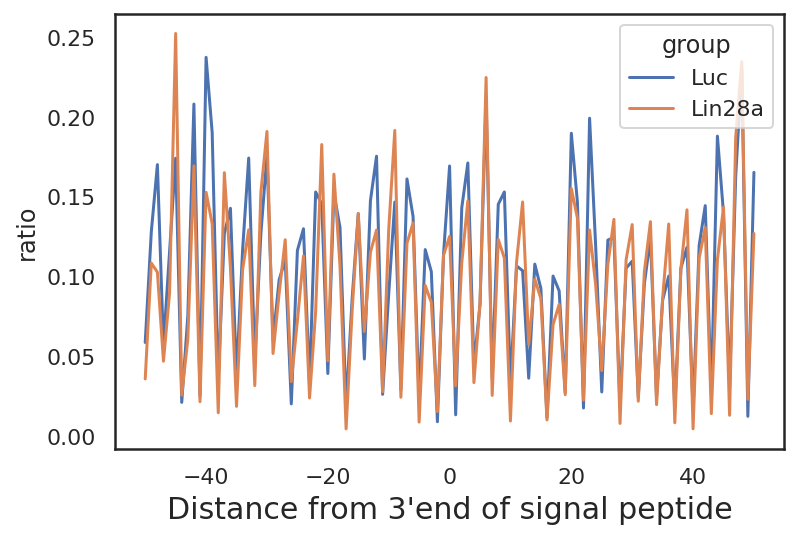

In [382]:
siLuc_signal = siLuc_signal.groupby('signaldist').mean()[['rpm_ratio']]
siLin28a_signal = siLin28a_signal.groupby('signaldist').mean()[['rpm_ratio']]

signal_merge = pd.merge(siLuc_signal, siLin28a_signal, on='signaldist', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
signal_merge.columns = ['signaldist','group','ratio']
signal_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
g = sns.lineplot(data=signal_merge, x='signaldist', y='ratio', hue='group')
g.set_xlabel("Distance from 3'end of signal peptide", fontsize=15)

# Test if rpf ratio decrease at stop codon site

In [345]:
siLin28a_df['reltostop-asite'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)
siLuc_df['reltostop-asite'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)

siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,signaldist,rpm_ratio,signaldist_group,cds_len,reltostop-asite
6973,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,230,0.141504,143,11.764706,False,1185,-955
6974,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,285,0.070752,198,5.882353,False,1185,-900
6975,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,525,0.070752,438,5.882353,False,1185,-660
6976,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,690,0.070752,603,5.882353,False,1185,-495
6977,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,717,0.070752,630,5.882353,False,1185,-468
...,...,...,...,...,...,...,...,...,...,...
1298581,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2487,0.070752,2412,1.075269,False,2796,-309
1298582,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2543,0.070752,2468,1.075269,False,2796,-253
1298583,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.070752,2568,1.075269,False,2796,-153
1298584,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2720,0.070752,2645,1.075269,False,2796,-76


<AxesSubplot:xlabel='reltostart-asite', ylabel='ratio'>

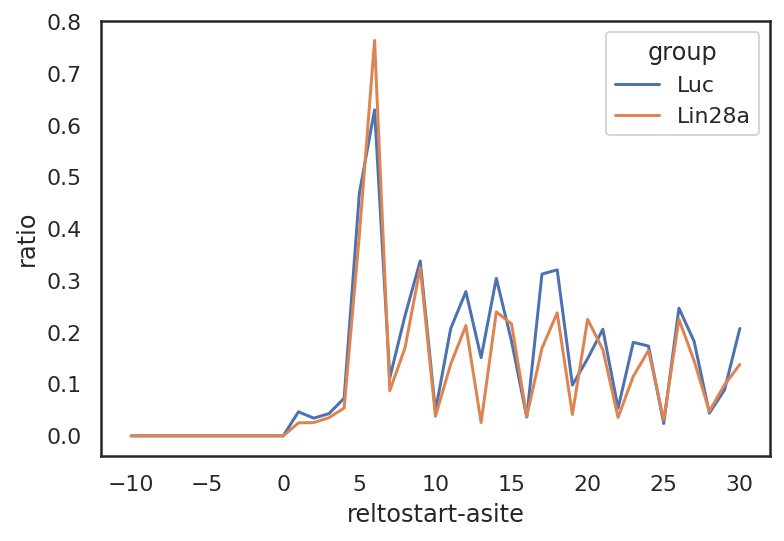

In [380]:
target_range=range(-10,31)
siLin28a_start = siLin28a_df.loc[siLin28a_df['reltostart-asite'].isin(target_range)]
siLuc_start = siLuc_df.loc[siLuc_df['reltostart-asite'].isin(target_range)]
siLin28a_start = siLin28a_start[['transcript_id','reltostart-asite','rpm_ratio']].set_index(['transcript_id','reltostart-asite'])
siLuc_start = siLuc_start[['transcript_id','reltostart-asite','rpm_ratio']].set_index(['transcript_id','reltostart-asite'])

siLuc_start = siLuc_start.reindex(pd.MultiIndex.from_product([siLuc_start.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostart-asite'])).fillna(0)
siLin28a_start = siLin28a_start.reindex(pd.MultiIndex.from_product([siLin28a_start.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostart-asite'])).fillna(0)

siLuc_start = siLuc_start.groupby('reltostart-asite').mean()[['rpm_ratio']]
siLin28a_start = siLin28a_start.groupby('reltostart-asite').mean()[['rpm_ratio']]

stop_merge = pd.merge(siLuc_start, siLin28a_start, on='reltostart-asite', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
stop_merge.columns = ['reltostart-asite','group','ratio']
stop_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
sns.lineplot(data=stop_merge, x='reltostart-asite', y='ratio', hue='group')

<AxesSubplot:xlabel='reltostop-asite', ylabel='ratio'>

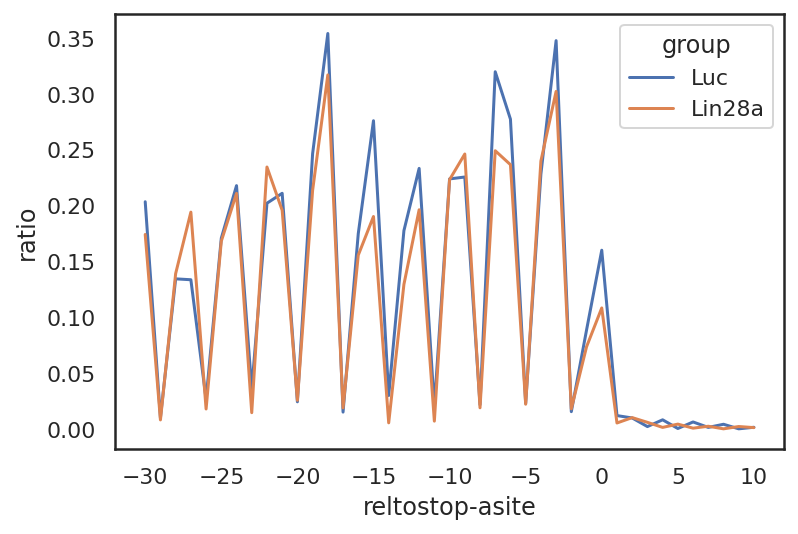

In [381]:
target_range = range(-30,11)
siLin28a_stop = siLin28a_df.loc[siLin28a_df['reltostop-asite'].isin(target_range)]
siLuc_stop = siLuc_df.loc[siLuc_df['reltostop-asite'].isin(target_range)]
siLin28a_stop = siLin28a_stop[['transcript_id','reltostop-asite','rpm_ratio']].set_index(['transcript_id','reltostop-asite'])
siLuc_stop = siLuc_stop[['transcript_id','reltostop-asite','rpm_ratio']].set_index(['transcript_id','reltostop-asite'])

siLuc_stop = siLuc_stop.reindex(pd.MultiIndex.from_product([siLuc_stop.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostop-asite'])).fillna(0)
siLin28a_stop = siLin28a_stop.reindex(pd.MultiIndex.from_product([siLin28a_stop.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostop-asite'])).fillna(0)

siLuc_stop = siLuc_stop.groupby('reltostop-asite').mean()[['rpm_ratio']]
siLin28a_stop = siLin28a_stop.groupby('reltostop-asite').mean()[['rpm_ratio']]

stop_merge = pd.merge(siLuc_stop, siLin28a_stop, on='reltostop-asite', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
stop_merge.columns = ['reltostop-asite','group','ratio']
stop_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
sns.lineplot(data=stop_merge, x='reltostop-asite', y='ratio', hue='group')

<AxesSubplot:xlabel='reltostop-asite', ylabel='ratio'>

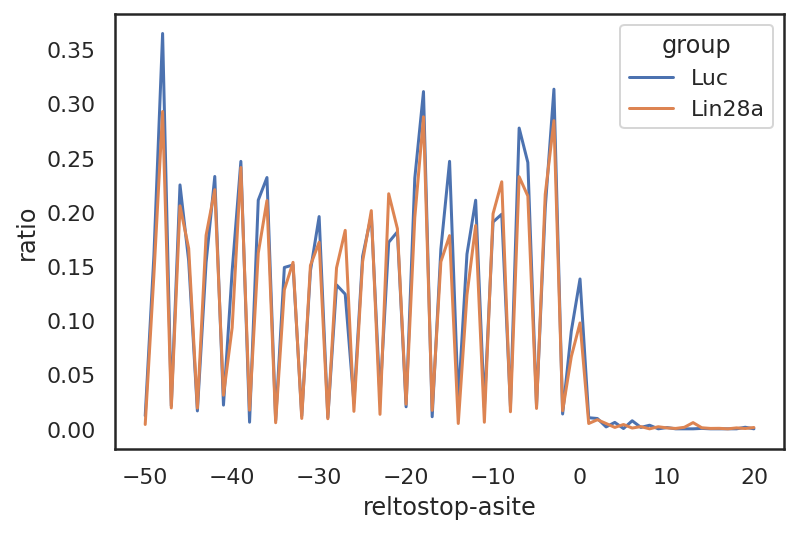

Lin28a binding motif가 CDS에 있어서 translation inhibition을 발생시켰다면, stop codon때 붙는 ratio가 감소해야하는데, 그렇지 않음.
따라서 CDS지역에서 rpf stalling과 같은 현상에 의한것이 아닐 가능성이 있음.

In [342]:
cdslen_dic

{'ENSMUST00000000001.5': 1065,
 'ENSMUST00000000003.14': 525,
 'ENSMUST00000000010.9': 753,
 'ENSMUST00000000028.14': 1701,
 'ENSMUST00000000049.6': 1038,
 'ENSMUST00000000058.7': 489,
 'ENSMUST00000000080.8': 957,
 'ENSMUST00000000087.13': 1995,
 'ENSMUST00000000090.8': 441,
 'ENSMUST00000000095.7': 2136,
 'ENSMUST00000000096.12': 1659,
 'ENSMUST00000000122.7': 1284,
 'ENSMUST00000000127.6': 1068,
 'ENSMUST00000000129.14': 2472,
 'ENSMUST00000000137.8': 1185,
 'ENSMUST00000000153.9': 1140,
 'ENSMUST00000000161.14': 2217,
 'ENSMUST00000000171.15': 948,
 'ENSMUST00000000175.6': 480,
 'ENSMUST00000000186.9': 756,
 'ENSMUST00000000187.7': 627,
 'ENSMUST00000000188.12': 870,
 'ENSMUST00000000193.6': 447,
 'ENSMUST00000000194.4': 315,
 'ENSMUST00000000199.8': 573,
 'ENSMUST00000000201.7': 5220,
 'ENSMUST00000000206.4': 1437,
 'ENSMUST00000000219.10': 1497,
 'ENSMUST00000000221.6': 1968,
 'ENSMUST00000000253.6': 1221,
 'ENSMUST00000000254.14': 810,
 'ENSMUST00000000260.13': 1038,
 'ENSMUST00

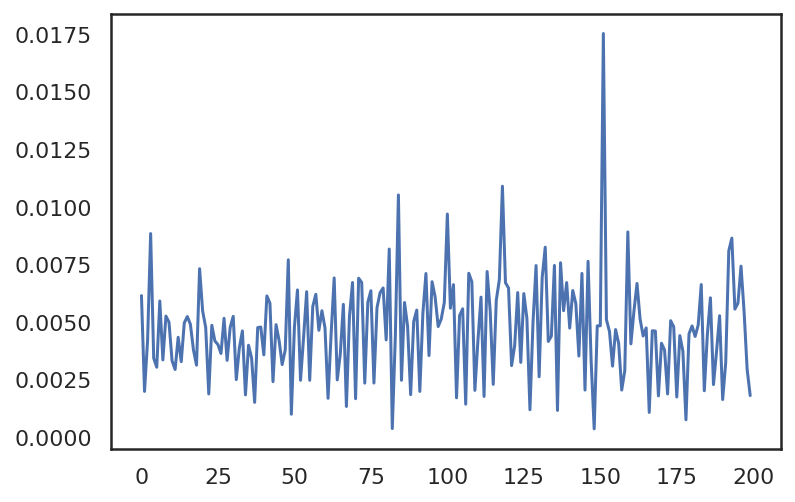

In [314]:
df = siLuc_df.groupby('signaldist').mean()[['rpm_ratio']]
plt.plot(df.loc[df.index.isin(range(0,200))])

In [315]:
siLuc_df.dropna()

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,signaldist,rpm_ratio,signaldist_group
8617,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,17,0.05368,-70,0.035714,True
8618,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,117,0.05368,30,0.035714,False
8619,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,180,0.05368,93,0.035714,False
8620,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,222,0.05368,135,0.035714,False
8621,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,236,0.05368,149,0.035714,False
...,...,...,...,...,...,...,...,...
1580017,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2490,0.05368,2415,0.014493,False
1580018,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2615,0.05368,2540,0.014493,False
1580019,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.05368,2568,0.014493,False
1580020,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2748,0.05368,2673,0.014493,False


In [186]:
siLuc_df.sort_values(by='signaldist')

Series([], Name: signaldist, dtype: int64)

In [59]:
siLuc_df['region'].value_counts()

Non-ER-associated    1221788
N-term signal         115940
Multi-pass             94978
No N-term signal       30975
Tail-anchored          10206
Name: region, dtype: int64

In [53]:
siLuc_depth

18628895

In [30]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLuc_trans = get_transmem_dist(siLuc_df, Dist)
siLuc_count = trans_typing(siLuc_trans, ratio=False)
siLuc_ratio = trans_typing(siLuc_trans, ratio=True)
siLuc_ratio

/tmp/ipykernel_151762/2907681967.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_151762/2907681967.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000000194,Multi-pass,downstream,0.343284
1,ENSMUSG00000000194,Multi-pass,transmembrane,0.417910
2,ENSMUSG00000000194,Multi-pass,upstream,0.238806
3,ENSMUSG00000000532,N-term signal,downstream,0.129032
4,ENSMUSG00000000532,N-term signal,transmembrane,0.516129
...,...,...,...,...
1005,ENSMUSG00000117924,Multi-pass,transmembrane,0.387097
1006,ENSMUSG00000117924,Multi-pass,upstream,0.303226
1007,ENSMUSG00000118664,Multi-pass,downstream,0.414966
1008,ENSMUSG00000118664,Multi-pass,transmembrane,0.353741


In [38]:
siLuc_trans

,gene_name,gene_id,transcript_id,reltostart-asite,count,dist_from_center,region,trans_type
4968,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,162,1,144,downstream,Multi-pass
4969,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,167,1,139,downstream,Multi-pass
4970,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,180,2,126,downstream,Multi-pass
4971,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,207,2,99,downstream,Multi-pass
4972,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,209,1,97,downstream,Multi-pass
...,...,...,...,...,...,...,...,...
1582812,Higd2a,ENSMUSG00000025868,ENSMUST00000026986.7,314,20,-143,upstream,Multi-pass
1582813,Higd2a,ENSMUSG00000025868,ENSMUST00000026986.7,315,11,-144,upstream,Multi-pass
1582814,Higd2a,ENSMUSG00000025868,ENSMUST00000026986.7,317,48,-146,upstream,Multi-pass
1582815,Higd2a,ENSMUSG00000025868,ENSMUST00000026986.7,318,2,-147,upstream,Multi-pass


In [31]:
siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_trans = get_transmem_dist(siLin28a_df, Dist)
siLin28a_count = trans_typing(siLin28a_trans, ratio = False)
siLin28a_ratio = trans_typing(siLin28a_trans, ratio = True)

siLin28a_ratio 

/tmp/ipykernel_151762/2907681967.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_151762/2907681967.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000000194,Multi-pass,downstream,0.238095
1,ENSMUSG00000000194,Multi-pass,transmembrane,0.514286
2,ENSMUSG00000000194,Multi-pass,upstream,0.247619
3,ENSMUSG00000000305,N-term signal,downstream,0.413793
4,ENSMUSG00000000305,N-term signal,transmembrane,0.206897
...,...,...,...,...
1130,ENSMUSG00000118662,N-term signal,downstream,0.606061
1131,ENSMUSG00000118662,N-term signal,transmembrane,0.393939
1132,ENSMUSG00000118664,Multi-pass,downstream,0.450413
1133,ENSMUSG00000118664,Multi-pass,transmembrane,0.351240


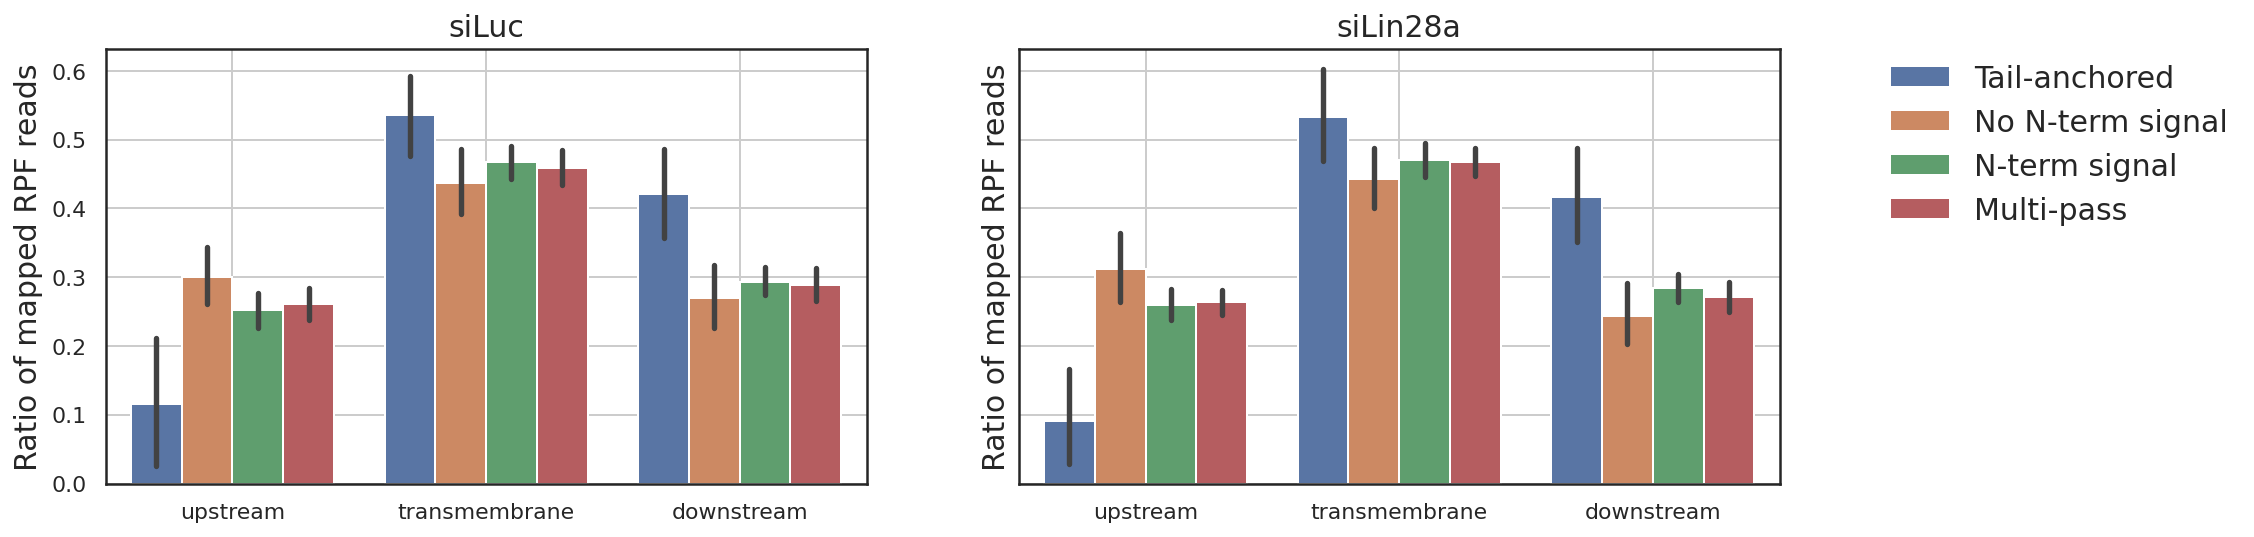

In [32]:
sns.set_theme(style='white')
fig, ax = plt.subplots(1,2, figsize=(15, 4), sharey=True)
title_list = ['siLuc','siLin28a']
for num, df in enumerate([siLuc_ratio, siLin28a_ratio]):
    g = sns.barplot(data=df, x='region', y='ratio',hue='trans_type', order=['upstream','transmembrane','downstream'], hue_order = ['Tail-anchored','No N-term signal','N-term signal','Multi-pass'], ax=ax[num])
    g.set_title(title_list[num], fontsize=15)
    g.legend([],[], frameon=False)
    handles, labels = plt.gca().get_legend_handles_labels()
    g.grid()
    g.set_xlabel('')
    g.set_ylabel('Ratio of mapped RPF reads', fontsize=15)
    fig.legend(handles[:], labels[:], bbox_to_anchor=(1.12,0.9), fontsize=15, ncol=1,frameon=False)

# Does siLin28a affect specific genes only

In [19]:
siLin28a_count.loc[siLin28a_count['gene_id']=='ENSMUSG00000050772']

,gene_id,trans_type,region,count
1682,ENSMUSG00000050772,Multi-pass,upstream,37


In [20]:
siLin28a_heatmap = siLin28a_count.pivot_table(index='gene_id', columns='region', values='count').fillna(0)
siLuc_heatmap = siLuc_count.pivot_table(index='gene_id', columns='region', values='count').fillna(0)

siLin28a_heatmap2 = siLin28a_heatmap.div(siLin28a_heatmap.sum(axis=1), axis=0)[['transmembrane']].fillna(0)
siLuc_heatmap2 = siLuc_heatmap.div(siLuc_heatmap.sum(axis=1), axis=0)[['transmembrane']].fillna(0)
heatmap_df = pd.merge(siLuc_heatmap2, siLin28a_heatmap2, on='gene_id', how='inner', suffixes=['_siLuc','_siLin28a'])
heatmap_df.columns = ['siLuc','siLin28a']
# sns.clustermap(data=heatmap_df, col_cluster=False, figsize=(7,7),  tree_kws=dict(linewidths=1))

In [21]:
heatmap_df['FC'] = heatmap_df['siLin28a'] / heatmap_df['siLuc']
heatmap_df['genesym'] = heatmap_df.index.map(genesym_dic)
heatmap_df.reset_index(inplace=True)
heatmap_df['trans_type'] = np.where(heatmap_df['gene_id'].isin(tail_genes), 'Tail-anchored',
                                            np.where(heatmap_df['gene_id'].isin(multi_genes), 'Multi-pass',
                                                    np.where(heatmap_df['gene_id'].isin(signal_genes), 'N-term signal',
                                                            np.where(heatmap_df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
heatmap_df = heatmap_df.sort_values(by='FC', ascending=False)
heatmap_df.head()

,gene_id,siLuc,siLin28a,FC,genesym,trans_type
158,ENSMUSG00000022967,0.176471,0.375000,2.125000,Ifnar1,N-term signal
573,ENSMUSG00000061633,0.250000,0.515152,2.060606,Ndufb11b,N-term signal
299,ENSMUSG00000029314,0.318182,0.642857,2.020408,Gpat3,Multi-pass
487,ENSMUSG00000043333,0.404255,0.743119,1.838242,Rhbdl2,Multi-pass
303,ENSMUSG00000029571,0.300000,0.515152,1.717172,Tmem106b,No N-term signal


In [22]:
heatmap_df.head(50)['gene_id'].to_csv('high_fc_geneid.txt', sep='\t', index=False, header=False)
heatmap_df['gene_id'].to_csv('ctl_fc_geneid.txt', sep='\t', index=False, header=False)

In [23]:
genesym

NameError: name 'genesym' is not defined

In [ ]:
siLin28a_heatmap.loc['ENSMUSG00000022967']

region
downstream       23.0
transmembrane    24.0
upstream         17.0
Name: ENSMUSG00000022967, dtype: float64

In [ ]:
siLuc_heatmap.loc['ENSMUSG00000022967']

region
downstream       17.0
transmembrane     9.0
upstream         25.0
Name: ENSMUSG00000022967, dtype: float64

In [ ]:
heatmap_df

In [ ]:
heatmap_df.sort_values(by='siLuc', ascending=False)

,siLuc,siLin28a
gene_id,,
ENSMUSG00000064357,0.990476,0.972603
ENSMUSG00000064363,0.982894,0.986723
ENSMUSG00000044026,0.972628,0.965812
ENSMUSG00000064358,0.970370,0.966887
ENSMUSG00000071253,0.966667,0.975000
...,...,...
ENSMUSG00000026223,0.160714,0.160976
ENSMUSG00000036275,0.142857,0.151852
ENSMUSG00000019891,0.134328,0.153061


In [ ]:
single_

In [ ]:
siLin28a_trans['trans_type'] = np.where(siLin28a_trans['gene_id'].isin(tail_genes), 'Tail-anchored',
                                        np.where(siLin28a_trans['gene_id'].isin(multi_genes), 'Multi-pass',
                                                np.where(siLin28a_trans['gene_id'].isin(signal_genes), 'N-term signal',
                                                        np.where(siLin28a_trans['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
siLin28a_trans

,gene_name,gene_id,transcript_id,reltostart-asite,count,dist_from_center,region,trans_type
3837,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,110,1,196,downstream,Multi-pass
3838,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,120,1,186,downstream,Multi-pass
3839,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,126,1,180,downstream,Multi-pass
3840,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,167,1,139,downstream,Multi-pass
3841,Abcd1,ENSMUSG00000031378,ENSMUST00000002084.14,169,2,137,downstream,Multi-pass
...,...,...,...,...,...,...,...,...
1304326,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1391,1,-107,upstream,Multi-pass
1304327,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1433,1,-149,upstream,Multi-pass
1304328,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1448,1,-164,upstream,Multi-pass
1304329,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1451,1,-167,upstream,Multi-pass


In [ ]:
siLin28a_trans.value_counts('trans_type')

trans_type
Multi-pass          73448
N-term signal       14265
No N-term signal     3919
Tail-anchored        2395
dtype: int64

In [ ]:
siLin28a_region = trans_rpf.groupby('region').sum()['count']
siLin28a_region = siLin28a_region / siLin28a_region.sum()
siLin28a_region

region
downstream       0.425488
transmembrane    0.339701
upstream         0.234811
Name: count, dtype: float64

In [ ]:
siLuc_region = trans_rpf.groupby('region').sum()['count']
siLuc_region = siLuc_region / siLuc_region.sum()
siLuc_region

region
downstream       0.393305
transmembrane    0.303777
upstream         0.302918
Name: count, dtype: float64

In [ ]:
df_combined = pd.merge(siLin28a_region, siLuc_region, on ='region', suffixes=['_siLin28a','_siLuc'])
df_combined.columns = ['siLin28a','siLuc']
df_combined = df_combined.stack().reset_index()
df_combined.columns = ['region','sample','ratio']
df_combined

,region,sample,ratio
0,downstream,siLin28a,0.425488
1,downstream,siLuc,0.393305
2,transmembrane,siLin28a,0.339701
3,transmembrane,siLuc,0.303777
4,upstream,siLin28a,0.234811
5,upstream,siLuc,0.302918


Text(0, 0.5, '')

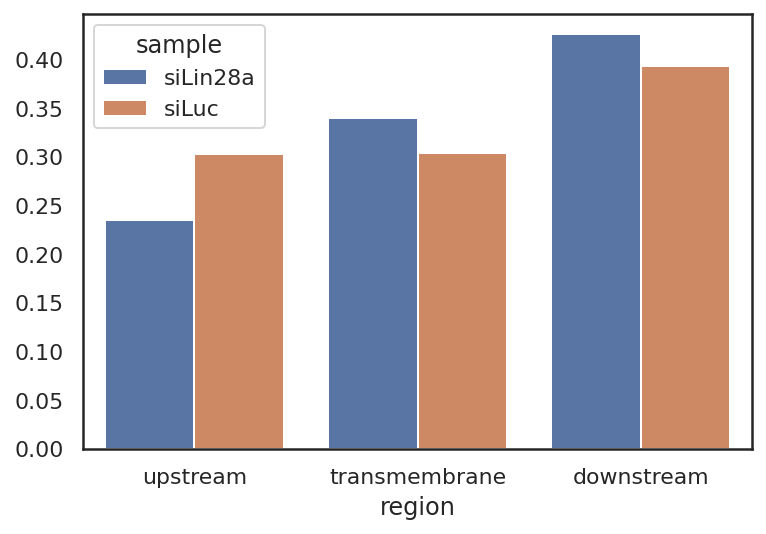

In [ ]:
sns.set_theme(style='white')
g = sns.barplot(x='region', y='ratio', hue='sample', data=df_combined, order=['upstream','transmembrane','downstream'])
g.set_ylabel('')

In [ ]:
# tail-anchored는 다른가 보기

In [ ]:
window = 12
stallcount = stallcount_all.div(stallcount_all.sum(axis=1),axis=0).copy()
stallcount_df = stallcount.stack().reset_index()
stallcount_df.columns = ['sample','position','fraction']
stallcount_df['group'] = stallcount_df['sample'].map(group_dic2)
stallcount_df = stallcount_df.groupby(['group','sample','position']).mean().reset_index()

stallcount_df['window_pos'] = stallcount_df['position'].apply(lambda x: x//window)
stallcount_df['fraction'] = stallcount_df['fraction']*100
stallcount_df = stallcount_df.groupby(['group','sample','window_pos']).sum().reset_index()
stallcount_df

In [ ]:
high_rpf2 = high_rpf.copy(deep=True)
high_rpf2['dist_from_center'] = high_rpf2.apply(lambda y: min(peakmid_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite'])) - y['reltostart-asite'] if (y['gene_id'] in peakmid_dic.keys()) else None, axis=1)
high_rpf2['closest_center'] = high_rpf2.apply(lambda y: min(peakmid_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite']))  if (y['gene_id'] in peakmid_dic.keys()) else None, axis=1)
high_rpf2 = high_rpf2.loc[high_rpf2['closest_center']>0]
high_rpf2['closest_center'] = high_rpf2['closest_center'].astype(int)

high_rpf2['closest_center_id'] = high_rpf2.apply(lambda x: x['gene_id']+"_"+str(x['closest_center']) if (x['closest_center']!=None) else None, axis=1)
high_rpf2

KeyboardInterrupt: 

In [ ]:
high_rpf['min_transmem_dist'] = memdf_all.apply(lambda y: min(membrane_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite'])) - y['reltostart-asite'], axis=1)

In [ ]:
pd.merge(high_rpf, membrane_prot, left_on = 'gene_id', right_on = 'ensembl_gene_id', how = 'inner')

,gene_name,gene_id,transcript_id,start,end,count,ensembl_gene_id,transmembrane
0,Slc28a1,ENSMUSG00000025726,ENSMUST00000026820.11,966,968,2,ENSMUSG00000025726,"[(249, 315), (327, 387), (441, 504), (534, 588..."
1,Slc28a1,ENSMUSG00000025726,ENSMUST00000026820.11,968,969,1,ENSMUSG00000025726,"[(249, 315), (327, 387), (441, 504), (534, 588..."
2,Slc28a1,ENSMUSG00000025726,ENSMUST00000026820.11,983,984,1,ENSMUSG00000025726,"[(249, 315), (327, 387), (441, 504), (534, 588..."
3,Slc28a1,ENSMUSG00000025726,ENSMUST00000026820.11,986,987,1,ENSMUSG00000025726,"[(249, 315), (327, 387), (441, 504), (534, 588..."
4,Slc28a1,ENSMUSG00000025726,ENSMUST00000026820.11,992,993,1,ENSMUSG00000025726,"[(249, 315), (327, 387), (441, 504), (534, 588..."
...,...,...,...,...,...,...,...,...
191689,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1832,1834,1,ENSMUSG00000039908,"[(102, 168), (168, 234), (246, 303), (318, 384..."
191690,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1844,1845,1,ENSMUSG00000039908,"[(102, 168), (168, 234), (246, 303), (318, 384..."
191691,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1878,1879,1,ENSMUSG00000039908,"[(102, 168), (168, 234), (246, 303), (318, 384..."
191692,Slc26a11,ENSMUSG00000039908,ENSMUST00000050880.8,1883,1884,1,ENSMUSG00000039908,"[(102, 168), (168, 234), (246, 303), (318, 384..."


In [ ]:
high_rpf

,chr,start,end,count,gene_chr,gene_start,gene_end,transcript_id,unknown,ori,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
0,chr1,4878056,4878057,3,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+,ENSMUSG00000025903,91,693,1723,0,2507,Lypla1
1,chr1,4878074,4878075,1,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+,ENSMUSG00000025903,91,693,1723,0,2507,Lypla1
2,chr1,4878089,4878090,1,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+,ENSMUSG00000025903,91,693,1723,0,2507,Lypla1
3,chr1,4878092,4878093,2,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+,ENSMUSG00000025903,91,693,1723,0,2507,Lypla1
4,chr1,4878095,4878096,1,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+,ENSMUSG00000025903,91,693,1723,0,2507,Lypla1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154520,chrX,161543664,161543665,8,chrX,161543397,161543703,ENSMUST00000033720.12,161543687,+,ENSMUSG00000031353,290,1278,676,0,2244,Rbbp7
154521,chrX,161543668,161543669,2,chrX,161543397,161543703,ENSMUST00000033720.12,161543687,+,ENSMUSG00000031353,290,1278,676,0,2244,Rbbp7
154522,chrX,161543671,161543672,3,chrX,161543397,161543703,ENSMUST00000033720.12,161543687,+,ENSMUSG00000031353,290,1278,676,0,2244,Rbbp7
154523,chrX,161543672,161543675,1,chrX,161543397,161543703,ENSMUST00000033720.12,161543687,+,ENSMUSG00000031353,290,1278,676,0,2244,Rbbp7
